In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, RandomizedSearchCV, cross_val_predict
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from scipy.stats import randint
import matplotlib.pyplot as plt
import seaborn as sns

# === Load data ===
train = pd.read_csv("/kaggle/input/preprocessing-2/train_processed.csv")
test  = pd.read_csv("/kaggle/input/preprocessing-2/test_processed.csv")

In [2]:
TARGET = "HotelValue"
features = [c for c in train.columns if c not in [TARGET, 'Id']]

X = train[features].copy()
y = train[TARGET].copy()

# === Encode categorical columns ===
cat_cols = X.select_dtypes('object').columns.tolist()
encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
X.loc[:, cat_cols] = encoder.fit_transform(X[cat_cols].astype(str))
test.loc[:, cat_cols] = encoder.transform(test[cat_cols].astype(str))

# === Log-transform target ===
y_log = np.log1p(y)

# === K-Fold CV and pipeline ===
kf = KFold(n_splits=5, shuffle=True, random_state=42)
pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('model', RandomForestRegressor(random_state=42, n_jobs=-1))
])

In [3]:
# === Hyperparameter distributions ===
param_dist = {
    'model__n_estimators': randint(500, 1000),
    'model__max_depth': [15, 20, 25],
    'model__min_samples_split': randint(2, 10),
    'model__min_samples_leaf': randint(1, 3),
    'model__max_features': ['sqrt', 'log2', 0.3, 0.5],
    'model__bootstrap': [True]
}

In [4]:
# === RandomizedSearchCV ===
rf_random = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=40,
    cv=kf,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    random_state=42,
    n_jobs=-1
)
rf_random.fit(X, y_log)

print("Best Parameters:", rf_random.best_params_)
print("Best CV RMSE (log-scale):", -rf_random.best_score_)

# === Predictions ===
y_train_pred_log = rf_random.predict(X)
y_train_pred = np.expm1(y_train_pred_log)
train_rmse = mean_squared_error(y, y_train_pred, squared=False)
print(f"Training RMSE (original scale): {train_rmse:,.2f}")

y_pred_log_cv = cross_val_predict(rf_random.best_estimator_, X, y_log, cv=kf, n_jobs=-1)
y_pred_cv = np.expm1(y_pred_log_cv)
val_rmse = mean_squared_error(y, y_pred_cv, squared=False)
print(f"Validation RMSE (original scale, CV): {val_rmse:,.2f}")

# === Feature importances ===
best_model = rf_random.best_estimator_['model']
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]

# === Individual Plots ===

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Parameters: {'model__bootstrap': True, 'model__max_depth': 15, 'model__max_features': 0.3, 'model__min_samples_leaf': 1, 'model__min_samples_split': 4, 'model__n_estimators': 634}
Best CV RMSE (log-scale): 0.1375285687338825
Training RMSE (original scale): 12,814.13
Validation RMSE (original scale, CV): 29,779.99


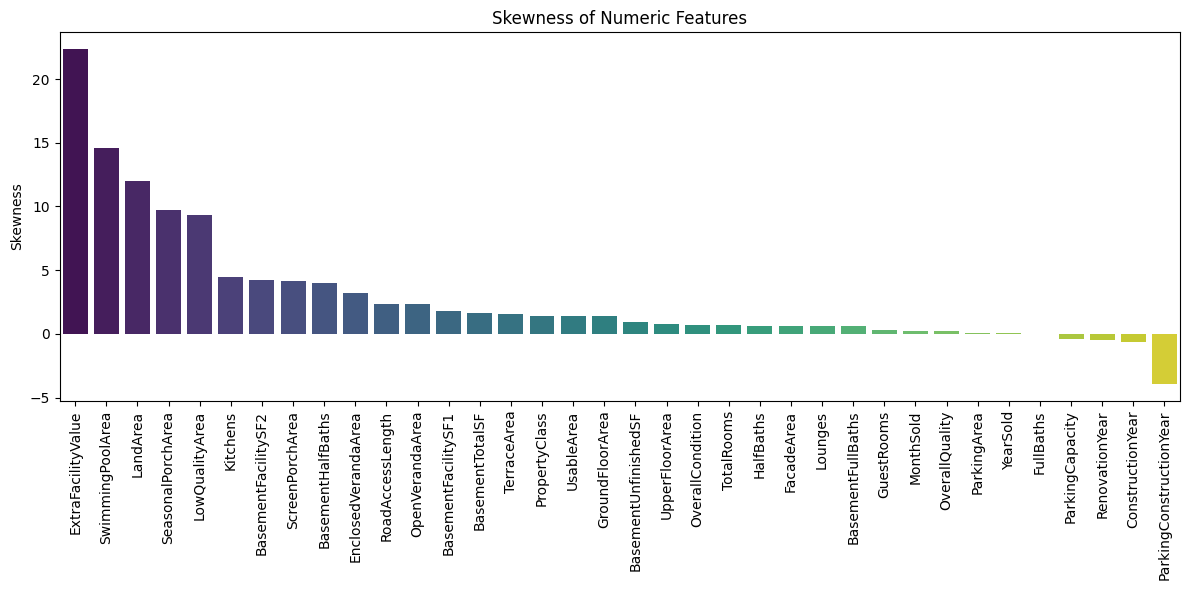

In [5]:
# 1. Skewness of numeric features
num_cols = X.select_dtypes(include=np.number).columns.tolist()
skew_vals = X[num_cols].skew().sort_values(ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=skew_vals.index, y=skew_vals.values, palette="viridis")
plt.xticks(rotation=90)
plt.ylabel("Skewness")
plt.title("Skewness of Numeric Features")
plt.tight_layout()
plt.show()

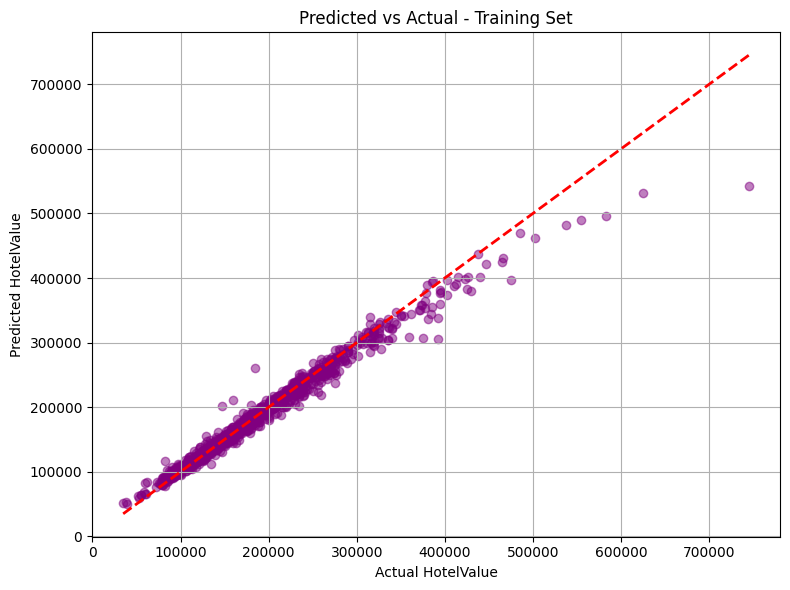

In [6]:
# 2. Predicted vs Actual (Training)
plt.figure(figsize=(8,6))
plt.scatter(y, y_train_pred, alpha=0.5, color='purple')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel("Actual HotelValue")
plt.ylabel("Predicted HotelValue")
plt.title("Predicted vs Actual - Training Set")
plt.grid(True)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


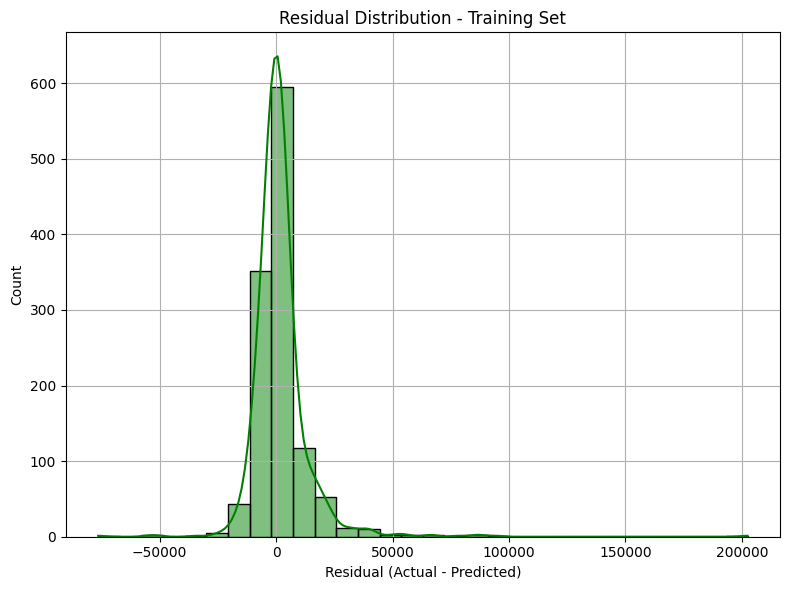

In [7]:
# 3. Residuals (Training)
residuals = y - y_train_pred
plt.figure(figsize=(8,6))
sns.histplot(residuals, bins=30, kde=True, color='green')
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Count")
plt.title("Residual Distribution - Training Set")
plt.grid(True)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


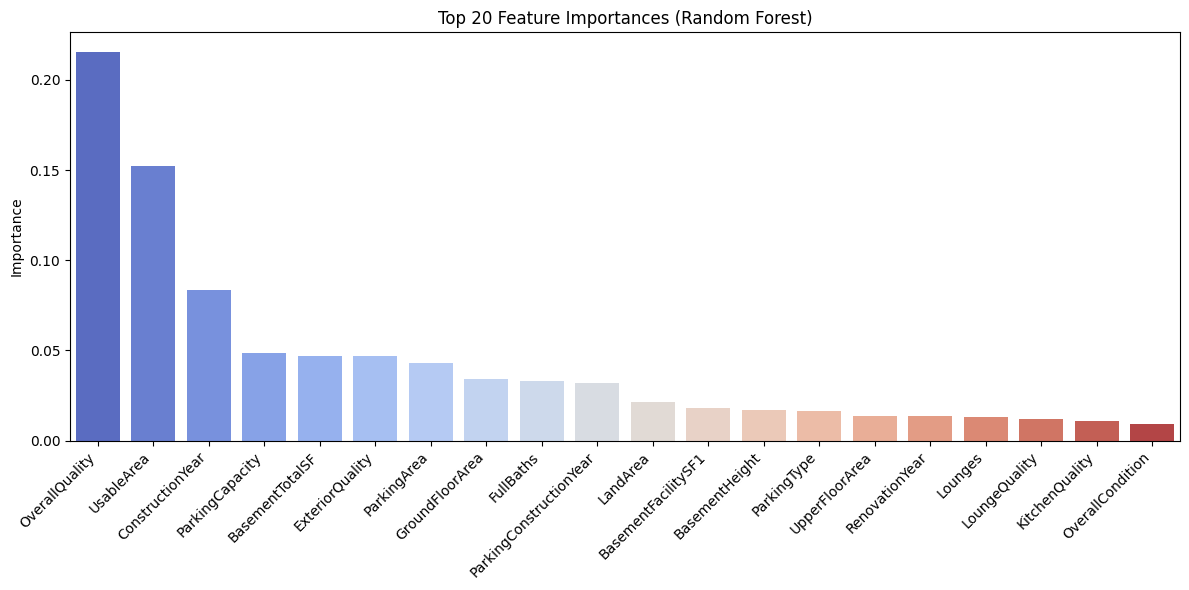

In [8]:
# 4. Feature Importances (Top 20)
plt.figure(figsize=(12,6))
sns.barplot(x=[X.columns[i] for i in indices[:20]], y=importances[indices][:20], palette="coolwarm")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Importance")
plt.title("Top 20 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()

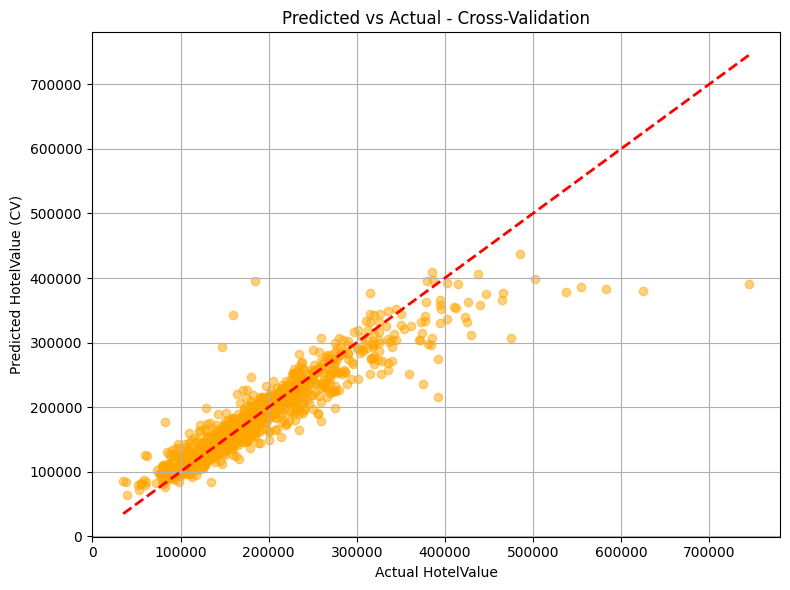

In [9]:
# 5. Predicted vs Actual (Cross-Validation)
plt.figure(figsize=(8,6))
plt.scatter(y, y_pred_cv, alpha=0.5, color='orange')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel("Actual HotelValue")
plt.ylabel("Predicted HotelValue (CV)")
plt.title("Predicted vs Actual - Cross-Validation")
plt.grid(True)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


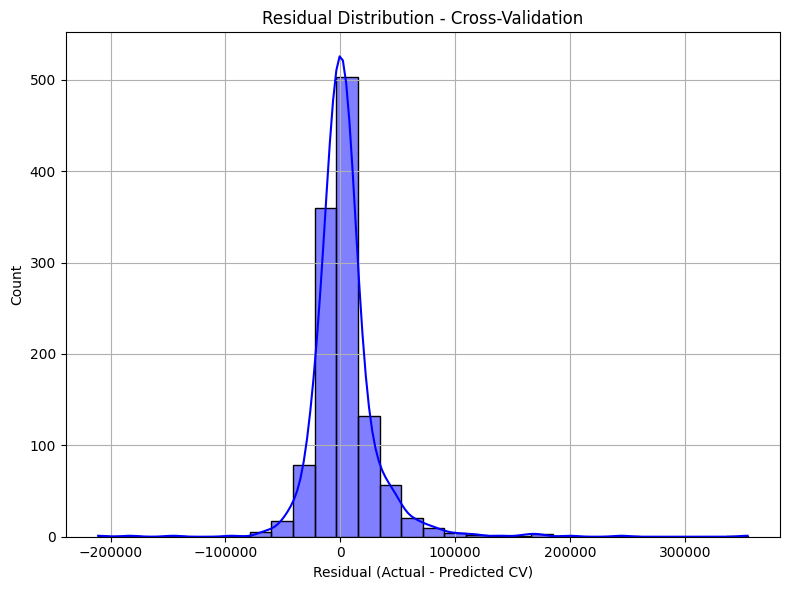

In [10]:
# 6. Residuals (Cross-Validation)
residuals_cv = y - y_pred_cv
plt.figure(figsize=(8,6))
sns.histplot(residuals_cv, bins=30, kde=True, color='blue')
plt.xlabel("Residual (Actual - Predicted CV)")
plt.ylabel("Count")
plt.title("Residual Distribution - Cross-Validation")
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
# === Predict on test set ===
test_input = test[features]
test_preds_log = rf_random.predict(test_input)
test_preds = np.expm1(test_preds_log)

submission = pd.DataFrame({"Id": test["Id"], "HotelValue": test_preds})
submission.to_csv("submission.csv", index=False)
print("Submission file 'submissioncsv' created successfully!")

Submission file 'submissioncsv' created successfully!
